# Beat Tracking (Ellis DP) for YTB-013 HEAD_IN

This notebook tracks beats from spectral novelty using dynamic programming (FMP `C6S3_BeatTracking`) and a supplied Fourier tempogram.

Inputs:
- `data/derived/tempogram/YTB-013_HEAD_IN_fourier.npy`
- spectral novelty for `YTB-013_HEAD_IN`

Outputs:
- `data/derived/beats/YTB-013_HEAD_IN_beats.npy` (beat times in seconds)

In [1]:
import json
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from scipy.interpolate import interp1d

# Add project root for dijon imports (works from notebooks/scratch or project root)
project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import AUDIO_MARKERS_DIR, DERIVED_DIR, RAW_AUDIO_DIR

TRACK = "YTB-013"
MARKER = "HEAD_IN"
FS_NOV = 100
THETA = np.arange(40, 321, dtype=np.float64)
N_TEMPO = 500
H_TEMPO = 10
TEMPO_BPM_OVERRIDE = None
FACTOR = 1.0


def _first_existing_path(candidates):
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("None of the candidate paths exists:\n" + "\n".join(str(p) for p in candidates))


# Load spectral novelty and resample to 100 Hz
nov_path = _first_existing_path(
    [
        DERIVED_DIR / "novelty" / f"{TRACK}_{MARKER}_spectral.npy",
        DERIVED_DIR / f"{TRACK}_{MARKER}_spectral.npy",
    ]
)
novelty_spec = np.load(nov_path)

sr = librosa.get_samplerate(path=RAW_AUDIO_DIR / f"{TRACK}.wav")
Fs_spec = sr / 256.0  # matches novelty.ipynb spectral novelty (H_spec=256)
t_in = np.arange(len(novelty_spec)) / Fs_spec
duration_s = len(novelty_spec) / Fs_spec
n_out = int(duration_s * FS_NOV)
t_out = np.linspace(0, duration_s, n_out, endpoint=False)
nov = interp1d(t_in, novelty_spec, kind="linear", fill_value="extrapolate")(t_out).astype(np.float64)

# Load supplied Fourier tempogram
tempogram_path = DERIVED_DIR / "tempogram" / f"{TRACK}_{MARKER}_fourier.npy"
X = np.load(tempogram_path)
if X.ndim != 2:
    raise ValueError(f"Expected 2D tempogram array, got shape {X.shape}")

# Reconstruct axes from agreed parameters
K, M = X.shape
if K == len(THETA):
    F_coef_BPM = THETA
else:
    F_coef_BPM = np.arange(40, 40 + K, dtype=np.float64)
T_coef = np.arange(M) * H_TEMPO / FS_NOV

# Global tempo estimate from time-averaged tempogram magnitude
tempo_profile = np.mean(np.abs(X), axis=1)
tempo_bpm_est = float(F_coef_BPM[int(np.argmax(tempo_profile))])
tempo_bpm = float(TEMPO_BPM_OVERRIDE) if TEMPO_BPM_OVERRIDE is not None else tempo_bpm_est
beat_ref = int(np.round(FS_NOV * 60.0 / tempo_bpm))

print(f"Novelty path: {nov_path}")
print(f"Tempogram path: {tempogram_path}")
print(f"Resampled novelty: {len(nov)} frames @ {FS_NOV} Hz")
print(f"Tempogram shape: {X.shape}")
print(f"Tempo estimate: {tempo_bpm_est:.2f} BPM | Using: {tempo_bpm:.2f} BPM")
print(f"beat_ref: {beat_ref} frames")


def compute_penalty(N, beat_ref):
    t = np.arange(1, N) / beat_ref
    penalty = -np.square(np.log2(t))
    return np.concatenate((np.array([0.0]), penalty))


def compute_beat_sequence(novelty, beat_ref, penalty=None, factor=1.0, return_all=False):
    N = len(novelty)
    if penalty is None:
        penalty = compute_penalty(N, beat_ref)
    penalty = penalty * factor

    novelty = np.concatenate((np.array([0.0]), novelty))
    D = np.zeros(N + 1)
    P = np.zeros(N + 1, dtype=int)
    D[1] = novelty[1]

    for n in range(2, N + 1):
        m_idx = np.arange(1, n)
        scores = D[m_idx] + penalty[n - m_idx]
        score_max = np.max(scores)
        if score_max <= 0:
            D[n] = novelty[n]
            P[n] = 0
        else:
            D[n] = novelty[n] + score_max
            P[n] = int(np.argmax(scores)) + 1

    B = np.zeros(N, dtype=int)
    k = 0
    B[k] = int(np.argmax(D))
    while P[B[k]] != 0:
        k += 1
        B[k] = P[B[k - 1]]
    B = B[: k + 1][::-1] - 1

    if return_all:
        return B, D, P
    return B


def beat_period_to_tempo(beat, Fs):
    return 60.0 / (beat / Fs)


B, D, P = compute_beat_sequence(nov, beat_ref=beat_ref, factor=FACTOR, return_all=True)
beat_times = B / FS_NOV
print(f"Detected beats: {len(B)} | Median IBI: {np.median(np.diff(beat_times)) if len(beat_times) > 1 else np.nan:.3f}s")

Novelty path: /Users/petermynett/dev/active/dijon/data/derived/novelty/YTB-013_HEAD_IN_spectral.npy
Tempogram path: /Users/petermynett/dev/active/dijon/data/derived/tempogram/YTB-013_HEAD_IN_fourier.npy
Resampled novelty: 3107 frames @ 100 Hz
Tempogram shape: (281, 311)
Tempo estimate: 252.00 BPM | Using: 252.00 BPM
beat_ref: 24 frames
Detected beats: 131 | Median IBI: 0.240s


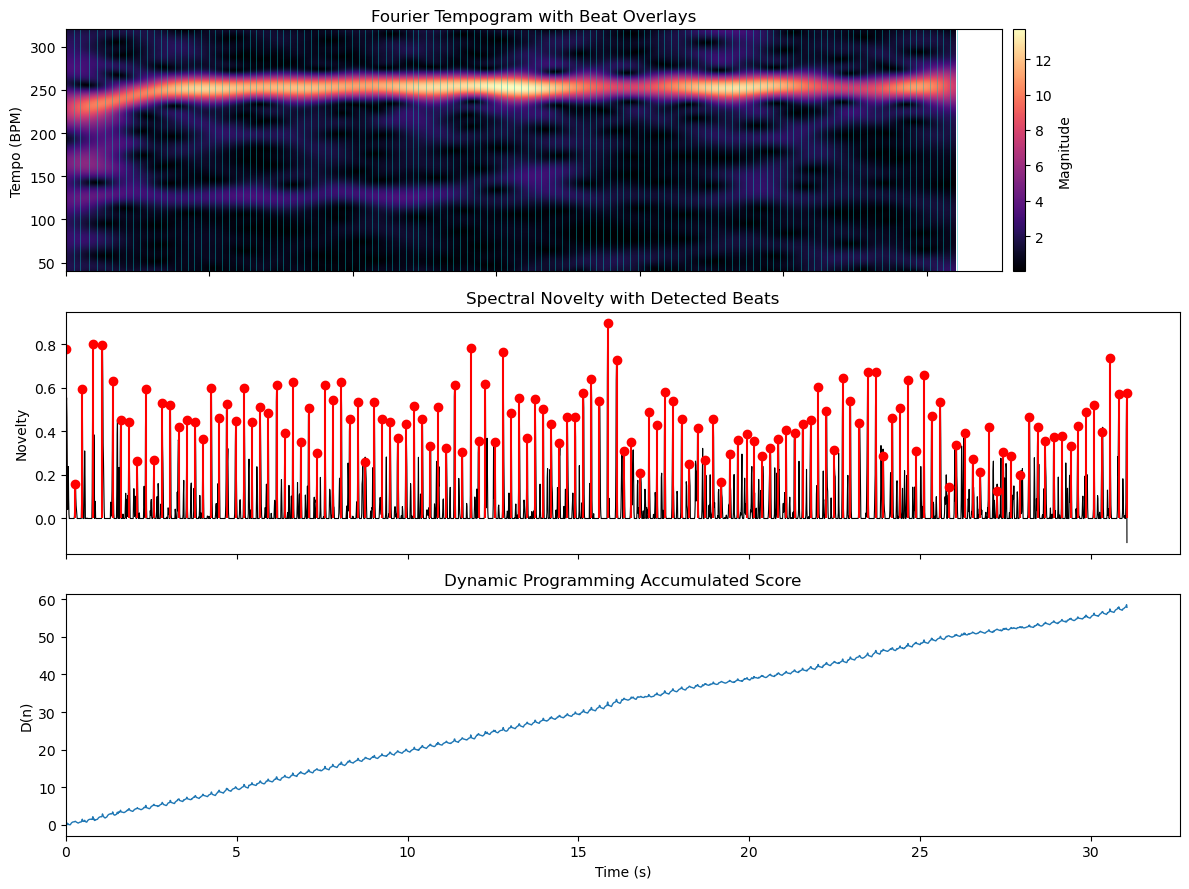

In [2]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# 1) Tempogram with beat overlays
t_end = T_coef[-1] if len(T_coef) else 0.0
im = axes[0].imshow(
    np.abs(X),
    origin="lower",
    aspect="auto",
    extent=[0, t_end, F_coef_BPM[0], F_coef_BPM[-1]],
    cmap="magma",
)
axes[0].set_ylabel("Tempo (BPM)")
axes[0].set_title("Fourier Tempogram with Beat Overlays")
for bt in beat_times:
    axes[0].axvline(bt, color="c", linewidth=0.6, alpha=0.5)
fig.colorbar(im, ax=axes[0], pad=0.01, label="Magnitude")

# 2) Novelty with beat markers
t_nov = np.arange(len(nov)) / FS_NOV
axes[1].plot(t_nov, nov, color="k", linewidth=0.8)
if len(B) > 0:
    axes[1].stem(
        beat_times,
        nov[B],
        linefmt="r-",
        markerfmt="ro",
        basefmt=" ",
    )
axes[1].set_ylabel("Novelty")
axes[1].set_title("Spectral Novelty with Detected Beats")

# 3) Accumulated score D(n)
axes[2].plot(t_nov, D[1:], color="tab:blue", linewidth=1.0)
axes[2].set_ylabel("D(n)")
axes[2].set_xlabel("Time (s)")
axes[2].set_title("Dynamic Programming Accumulated Score")

plt.tight_layout()
plt.show()

In [3]:
# Load marker segment audio for sonification
marker_path = AUDIO_MARKERS_DIR / f"{TRACK}_markers.json"
with open(marker_path, "r", encoding="utf-8") as f:
    marker_payload = json.load(f)

# Support multiple marker JSON schemas
try:
    if isinstance(marker_payload, list):
        marker_list = marker_payload
        schema_mode = "top_level_list"
    elif isinstance(marker_payload, dict) and "markers" in marker_payload:
        marker_list = marker_payload["markers"]
        schema_mode = "dict_markers"
    elif isinstance(marker_payload, dict) and "entries" in marker_payload:
        entries = marker_payload["entries"]
        if not isinstance(entries, list) or len(entries) == 0:
            raise ValueError("'entries' exists but is empty or not a list")
        latest_entry = entries[0]
        if not isinstance(latest_entry, dict) or "markers" not in latest_entry:
            raise ValueError("entries[0] missing 'markers'")
        marker_list = latest_entry["markers"]
        schema_mode = "dict_entries_markers"
    else:
        raise KeyError("Unsupported marker payload schema")
except Exception:
    raise

name_to_marker = {m.get("name"): m for m in marker_list if isinstance(m, dict) and "name" in m}

if MARKER in name_to_marker and "start" in name_to_marker[MARKER] and "end" in name_to_marker[MARKER]:
    marker_entry = name_to_marker[MARKER]
    start_s = float(marker_entry["start"])
    end_s = float(marker_entry["end"])
    marker_mode = "segment_marker_start_end"
elif f"{MARKER}_START" in name_to_marker and f"{MARKER}_END" in name_to_marker:
    start_s = float(name_to_marker[f"{MARKER}_START"]["position"])
    end_s = float(name_to_marker[f"{MARKER}_END"]["position"])
    marker_mode = "paired_position_markers"
else:
    raise KeyError(
        f"Could not resolve marker bounds for '{MARKER}'. "
        f"Available sample names: {list(name_to_marker.keys())[:8]}"
    )

x_full, sr = librosa.load(RAW_AUDIO_DIR / f"{TRACK}.wav", sr=None, mono=True)
i0 = int(np.floor(start_s * sr))
i1 = int(np.ceil(end_s * sr))
x_seg = x_full[i0:i1]

clicks = librosa.clicks(times=beat_times, sr=sr, click_freq=1000, length=len(x_seg))
audio_mix = x_seg + 0.8 * clicks
print(f"Segment duration: {len(x_seg)/sr:.2f}s | Beats in segment: {len(beat_times)}")
display(Audio(audio_mix, rate=sr))

# Save beats (seconds)
beats_dir = DERIVED_DIR / "beats"
beats_dir.mkdir(parents=True, exist_ok=True)
out_path = beats_dir / f"{TRACK}_{MARKER}_beats.npy"
np.save(out_path, beat_times)
print(f"Saved beat times to: {out_path}")

# TODO: Further development: integrate notebook_ui cursor-synced playback wrapper.

Segment duration: 31.08s | Beats in segment: 131


Saved beat times to: /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-013_HEAD_IN_beats.npy
